# Lab Four: Multi-Layer Perceptron
By Saaketh Koka, Vedant Nilabh, Elias Mann and Rayaan Irani 

In this lab, we will make a multi-layer perceptron (a type of Neural Network) which takes in data provided by the US Census Bearueau on a county-wide basis to determine the child poverty level in the county. 

## Load, Split, and Balance

In [504]:
#Import statements for the program 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os 
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings('ignore')

Median number of census tracts per county: 9.0
Mean number of census tracts per county: 37.21494370522006


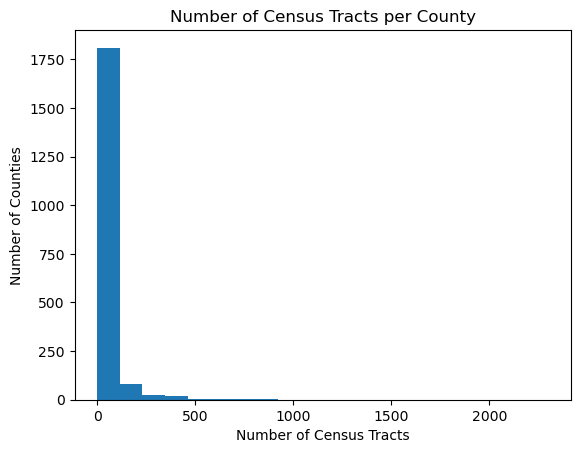

In [505]:
#Loads in all of the data into a Pandas Data Frame
df = pd.read_csv("acs2017_census_tract_data.csv")

df.dropna(inplace=True) #Removes rows that have missing values 

#This converts all of the string values into numerical values
le = preprocessing.LabelEncoder()
df['State'] = le.fit_transform(df['State'])
df['County'] = le.fit_transform(df['County'])

counts = list(df["County"].groupby(df["County"]).count())
plt.hist(counts, bins = 20)
plt.title("Number of Census Tracts per County")
plt.xlabel("Number of Census Tracts")
plt.ylabel("Number of Counties")

#Shows the median number of census tracts per county
print("Median number of census tracts per county: " + str(np.median(counts)))

#Shows the mean number of census tracts per county
print("Mean number of census tracts per county: " + str(np.mean(counts)))


Counites should be kept as a feature. This is becuase counties like states play a role in funding poverty relief programs. The extent to which these programs are funded is a result of the relative wealth of the county (as most county tax revenue is derived from property taxes). Due to this, it is possible that two census tracks that are very similar in other data types may differ greatly in poverty levels because one is surronded by a richer area and thus gets more county funding and the other does not. 

Text(0, 0.5, 'Number of Census Tracts')

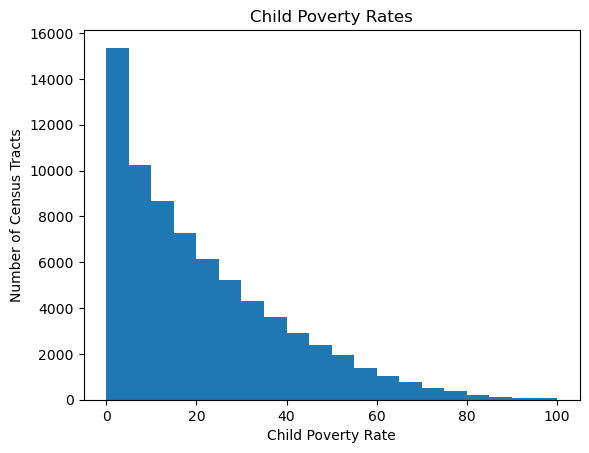

In [506]:
# Create histogram of child poverty rates
plt.hist(df["ChildPoverty"], bins = 20)
plt.title("Child Poverty Rates")
plt.xlabel("Child Poverty Rate")
plt.ylabel("Number of Census Tracts")


As can seen by the chart, the child poverty rates amongst census tracks do not follow a uniform or Gausian distribution. The data shows a mode near zero with the number of census tracks suffering a higher rates falling steadly from there. Due to the data being monomodal, there is no clear points to split the data into classes from Child Poverty Rates themselves. For this reason, we are spliting the data into classes each with an equal number of census tracks. This will allow us to use the full dataset for training and testing instead of having to throw away data to keep the classes balanced.

In [507]:
# Discreatizing the Unemployment Variable into 4 classes, 0,1,2,3
classes = pd.qcut(df['ChildPoverty'], 4, labels = [0,1,2,3])
df['ChildPoverty'] = classes

# Dropping the TractId column because it is useless for our model
df.drop('TractId', axis = 1, inplace = True)


# Splitting the data so that each set has almost an equal number of each class
X_train, X_test, y_train, y_test = train_test_split(df.drop('ChildPoverty', axis = 1), df['ChildPoverty'], test_size = 0.2, stratify = df['ChildPoverty'])

# Converting the data into numpy arrays
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

## Initial Modeling

In [508]:
# Example adapted from https://github.com/rasbt/python-machine-learning-book/blob/master/code/ch12/ch12.ipynb
# Original Author: Sebastian Raschka

# This is the optional book we use in the course, excellent intuitions and straightforward programming examples
# please note, however, that this code has been manipulated to reflect our assumptions and notation.
import numpy as np
from scipy.special import expit
import pandas as pd
import sys

# start with a simple base classifier, which can't be fit or predicted
# it only has internal classes to be used by classes that will subclass it
class TwoLayerPerceptronBase(object):
    def __init__(self, n_hidden=30,
                 C=0.0, epochs=500, eta=0.001, random_state=None,
                 alpha=0.0, decrease_const=0.0, shuffle=True,
                 minibatches=1):
        np.random.seed(random_state)
        self.n_hidden = n_hidden
        self.l2_C = C
        self.epochs = epochs
        self.eta = eta
        # Mini Batch params:
        self.alpha = alpha
        self.decrease_const = decrease_const
        self.shuffle = shuffle
        self.minibatches = minibatches

        
    @staticmethod
    def _encode_labels(y):
        """Encode labels into one-hot representation"""
        onehot = pd.get_dummies(y).values.T
            
        return onehot

    def _initialize_weights(self):
        """Initialize weights Glorot and He normalization."""
        init_bound = 4*np.sqrt(6. / (self.n_hidden + self.n_features_))
        W1 = np.random.uniform(-init_bound, init_bound,(self.n_hidden, self.n_features_))

        # reduce the final layer magnitude in order to balance the size of the gradients
        # between 
        init_bound = 4*np.sqrt(6 / (self.n_output_ + self.n_hidden))
        W2 = np.random.uniform(-init_bound, init_bound,(self.n_output_, self.n_hidden)) 
        
        b1 = np.zeros((self.n_hidden, 1))
        b2 = np.zeros((self.n_output_, 1))
        
        return W1, W2, b1, b2
    
    @staticmethod
    def _sigmoid(z):
        """Use scipy.special.expit to avoid overflow"""
        # 1.0 / (1.0 + np.exp(-z))
        return expit(z)
    
    
    @staticmethod
    def _L2_reg(lambda_, W1, W2):
        """Compute L2-regularization cost"""
        # only compute for non-bias terms
        return (lambda_/2.0) * np.sqrt(np.mean(W1[:, 1:] ** 2) + np.mean(W2[:, 1:] ** 2))
    
    def _cost(self,A3,Y_enc,W1,W2):
        '''Get the objective function value'''
        cost = -np.mean(np.nan_to_num((Y_enc*np.log(A3)+(1-Y_enc)*np.log(1-A3))))
        L2_term = self._L2_reg(self.l2_C, W1, W2)
        return cost + L2_term
    
    def _feedforward(self, X, W1, W2, b1, b2):
        """Compute feedforward step
        -----------
        X : Input layer with original features.
        W1: Weight matrix for input layer -> hidden layer.
        W2: Weight matrix for hidden layer -> output layer.
        ----------
        a1-a3 : activations into layer (or output layer)
        z1-z2 : layer inputs 

        """
        A1 = X.T
        Z1 = W1 @ A1 + b1
        A2 = self._sigmoid(Z1)
        Z2 = W2 @ A2 + b2
        A3 = self._sigmoid(Z2)
        return A1, Z1, A2, Z2, A3
    
    def _get_gradient(self, A1, A2, A3, Z1, Z2, Y_enc, W1, W2):
        """ Compute gradient step using backpropagation.
        """
        # vectorized backpropagation
        V2 = (A3-Y_enc) # <- this is only line that changed
        V1 = A2*(1-A2)*(W2.T @ V2)
        
        gradW2 = V2 @ A2.T
        gradW1 = V1 @ A1.T
        
        gradb2 = np.sum(V2, axis=1).reshape((-1,1))
        gradb1 = np.sum(V1, axis=1).reshape((-1,1))
        
        # regularize weights that are not bias terms
        gradW1 += W1 * self.l2_C
        gradW2 += W2 * self.l2_C

        return gradW1, gradW2, gradb1, gradb2
    
    def predict(self, X):
        """Predict class labels"""
        _, _, _, _, A3 = self._feedforward(X, self.W1, self.W2, self.b1, self.b2)
        y_pred = np.argmax(A3, axis=0)
        return y_pred
    def fit(self, X, y, print_progress=False, XY_test=None):
        """ Learn weights from training data. With mini-batch"""
        X_data, y_data = X.copy(), y.copy()
        Y_enc = self._encode_labels(y)
        
        # init weights and setup matrices
        self.n_features_ = X_data.shape[1]
        self.n_output_ = Y_enc.shape[0]
        self.W1, self.W2, self.b1, self.b2 = self._initialize_weights()

        # start momentum at zero for previous updates
        rho_W1_prev = np.zeros(self.W1.shape) # for momentum
        rho_W2_prev = np.zeros(self.W2.shape) # for momentum

        self.cost_ = []
        self.score_ = []
        # get starting acc
        self.score_.append(accuracy_score(y_data,self.predict(X_data)))
        # keep track of validation, if given
        if XY_test is not None:
            X_test = XY_test[0].copy()
            y_test = XY_test[1].copy()
            self.val_score_ = []
            self.val_score_.append(accuracy_score(y_test,self.predict(X_test)))
            
        for i in range(self.epochs):

            # adaptive learning rate
            # \frac{\eta}{1+\epsilon\cdot k}
            eta = self.eta / (1 + self.decrease_const*i)

            if print_progress>0 and (i+1)%print_progress==0:
                sys.stderr.write('\rEpoch: %d/%d' % (i+1, self.epochs))
                sys.stderr.flush()

            if self.shuffle:
                idx_shuffle = np.random.permutation(y_data.shape[0])
                X_data, Y_enc, y_data = X_data[idx_shuffle], Y_enc[:, idx_shuffle], y_data[idx_shuffle]

            mini = np.array_split(range(y_data.shape[0]), self.minibatches)
            mini_cost = []
            for idx in mini:
                # feedforward
                A1, Z1, A2, Z2, A3 = self._feedforward(X_data[idx],
                                                       self.W1,
                                                       self.W2,
                                                       self.b1,
                                                       self.b2
                                                      )
                
                cost = self._cost(A3,Y_enc[:, idx],self.W1,self.W2)
                mini_cost.append(cost) # this appends cost of mini-batch only

                # compute gradient via backpropagation
                gradW1, gradW2, gradb1, gradb2 = self._get_gradient(A1=A1, A2=A2, A3=A3, Z1=Z1, Z2=Z2, 
                                                  Y_enc=Y_enc[:, idx],
                                                  W1=self.W1,W2=self.W2)

                # momentum calculations
                rho_W1, rho_W2 = eta * gradW1, eta * gradW2
                self.W1 -= (rho_W1 + (self.alpha * rho_W1_prev)) # update with momentum
                self.W2 -= (rho_W2 + (self.alpha * rho_W2_prev)) # update with momentum
                self.b1 -= eta * gradb1
                self.b2 -= eta * gradb2
                rho_W1_prev, rho_W2_prev = rho_W1, rho_W2
                

            self.cost_.append(mini_cost)
            self.score_.append(accuracy_score(y_data,self.predict(X_data)))
            if XY_test is not None:
                self.val_score_.append(accuracy_score(y_test,self.predict(X_test)))
            
        return self

In [509]:
hyper_params = {'n_hidden': 30,
            'C': 0.1, 'epochs': 100, 'eta': 0.001,
            'alpha': 0.001, 'decrease_const': 1e-5, 'minibatches': 50,
            'shuffle': True, 'random_state': 1}
model1 = TwoLayerPerceptronBase(**hyper_params)
model1.fit(X_train,y_train,print_progress=1,XY_test=(X_test,y_test))


Epoch: 100/100

Test accuracy: 25.09%
Value Counts of classes predicted: 
2    14452
0       83
3        9
dtype: int64


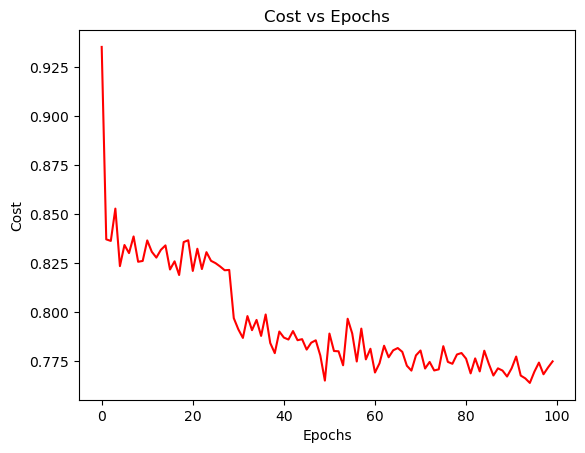

In [510]:
y_pred = model1.predict(X_test)
print('Test accuracy: %.2f%%' % (accuracy_score(y_test, y_pred)*100))
# print out the value counts of each item in y_pred:
print("Value Counts of classes predicted: ")
print(pd.Series(y_pred).value_counts())
cost_avgs = np.mean(model1.cost_,axis=1)
plt.plot(range(len(cost_avgs)), cost_avgs, color='red')
plt.ylabel('Cost')
plt.xlabel('Epochs')
plt.title('Cost vs Epochs')
plt.show()

This model is run without any scaling or one-hot encoding of the features. While the cost decreases slightly over the 100 epochs, the accuracy is very low. When testing the model, the model almost excusivley predicts a certain class for all of the data suggesting that the model is training to simply predict a certain class. Hopefully scaling the feature data can fix this issue.

In [511]:
# Scaling the feature data that is fit X_train data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scl = X_train.copy()
X_test_scl = X_test.copy()

X_train_scl[:,2:] = scaler.fit_transform(X_train[:,2:])
X_test_scl[:,2:] = scaler.fit_transform(X_test[:,2:])

# Running with the same hyperparameters as above
model2 = TwoLayerPerceptronBase(**hyper_params)
model2.fit(X_train_scl,y_train,print_progress=1,XY_test=(X_test_scl,y_test))

Epoch: 100/100

Test accuracy: 24.97%
Value Counts of classes predicted: 
2    14507
1       34
3        3
dtype: int64


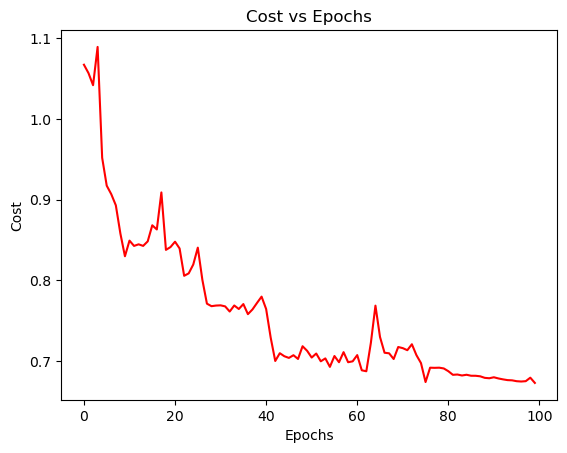

In [512]:
y_pred_scl = model2.predict(X_test_scl)
print('Test accuracy: %.2f%%' % (accuracy_score(y_test, y_pred_scl)*100))
# print out the value counts of each item in y_pred_scl:
print("Value Counts of classes predicted: ")
print(pd.Series(y_pred_scl).value_counts())
cost_avgs = np.mean(model2.cost_,axis=1)
plt.plot(range(len(cost_avgs)), cost_avgs, color='red')
plt.ylabel('Cost')
plt.xlabel('Epochs')
plt.title('Cost vs Epochs')
plt.show()

The results remain pretty bad, the cost is still largely hovering in the same range across the epochs, although we are getting slightly more diversity in the outputs of the Perceptron now. This makes it seem like the single biggest issue with the data itself is that the large values of the label encoded categorical features, specifically county because it has so many unique values may be making the optimization very difficult for the network. Let's see if one hot encoding the categorical variables makes a difference.

In [513]:
# Standard Scale X_train and X_test except for the first 2 columns
scaler = preprocessing.StandardScaler().fit(X_train[:,2:])

X_train_scl = X_train.copy()
X_test_scl = X_test.copy()

X_train_scl[:,2:] = scaler.transform(X_train[:,2:])
X_test_scl[:,2:] = scaler.transform(X_test[:,2:])


X_train_one_hot = X_train_scl[:,:2]
X_test_one_hot = X_test_scl[:,:2]


X_one_hot = np.concatenate((X_train_one_hot,X_test_one_hot),axis=0)

# One Hot Encoding
enc = preprocessing.OneHotEncoder()
enc.fit(X_one_hot)
X_train_one_hot = enc.transform(X_train_one_hot).toarray()
X_test_one_hot = enc.transform(X_test_one_hot).toarray()

# Concatenating scaled and one hot encoded features
X_train_scl_one_hot = np.concatenate((X_train_one_hot,X_train_scl[:,2:]),axis=1)
X_test_scl_one_hot = np.concatenate((X_test_one_hot,X_test_scl[:,2:]),axis=1)


model3 = TwoLayerPerceptronBase(**hyper_params)
model3.fit(X_train_scl_one_hot,y_train,print_progress=1,XY_test=(X_test_scl_one_hot,y_test))


Epoch: 100/100

Test accuracy: 73.55%
Value Counts of classes predicted: 
1    3840
3    3791
2    3658
0    3255
dtype: int64


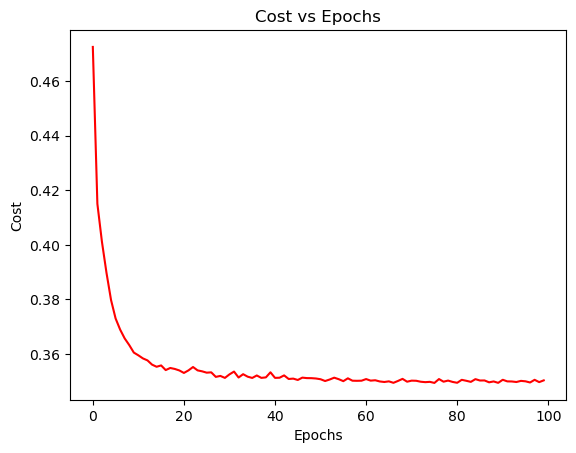

In [514]:
y_pred_scl_one_hot = model3.predict(X_test_scl_one_hot)
print('Test accuracy: %.2f%%' % (accuracy_score(y_test, y_pred_scl_one_hot)*100))
print("Value Counts of classes predicted: ")
print(pd.Series(y_pred_scl_one_hot).value_counts())
cost_avgs = np.mean(model3.cost_,axis=1)
plt.plot(range(len(cost_avgs)), cost_avgs, color='red')
plt.ylabel('Cost')
plt.xlabel('Epochs')
plt.title('Cost vs Epochs')
plt.show()

One Hot encoding and scaling the features provides a huge boost in performance, and allows the network to actually train properly, as seen by how the loss converges in the graph above, as well as the much higher accuracy (much, much better than random chance, unlike the previous networks).  We theorize that this is likely due to the combination of scaling and one hot encoding simultaneous keeping the features in small ranges and preventing the network from learning incorrect ordinal patterns in the categorical data (A state encoded with a higher value isn't actually greater in any way). However, we think the single biggest factor is probably the fact that this keeps the dynamic ranges of all the variables constrained, and thus prevents bias among variables, and allows for the glorot initialization to be effective so that the activations do not saturate early (which can cause the Cross-Entropy loss and the gradients to become unstable).

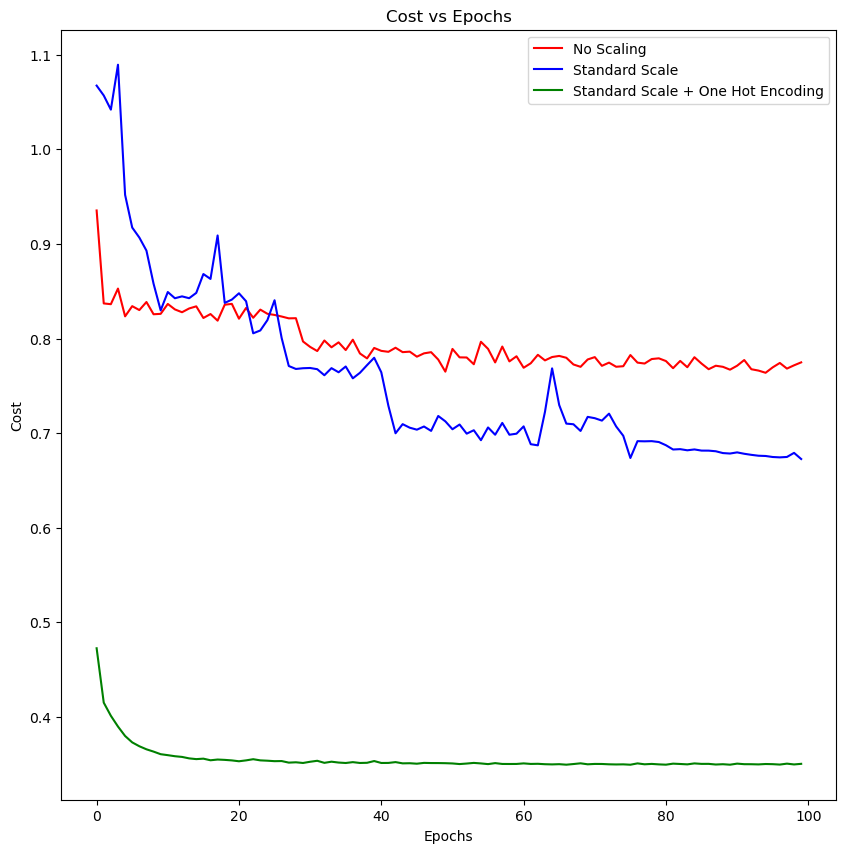

In [515]:
cost_avgs1 = np.mean(model1.cost_,axis=1)
cost_avgs2 = np.mean(model2.cost_,axis=1)
cost_avgs3 = np.mean(model3.cost_,axis=1)
plt.figure(figsize=(10, 10))
plt.plot(range(len(cost_avgs1)), cost_avgs1, color='red',label='No Scaling')
plt.plot(range(len(cost_avgs2)), cost_avgs2, color='blue',label='Standard Scale')
plt.plot(range(len(cost_avgs3)), cost_avgs3, color='green',label='Standard Scale + One Hot Encoding')
plt.ylabel('Cost') 
plt.xlabel('Epochs')
plt.title('Cost vs Epochs')
plt.legend()

As we can see in the figure, No Scaling and only Scaling the numerical columns have very similar performance. Whereas, the model which trained on Scaled and One-hot-encoded data outperformed (in training and testing) the other two models by a significant margin. The reason the model which trained only on Scaled numerical data performed poorly is because the unscaled label encoded values likley caused the gradients to explode. These three models highlight the importance of Scaling and One-hot-encoding the data during the preprocessing stage.

## Modeling

In [516]:
# Using scaled and one-hot encoded data by default
X_train = X_train_scl_one_hot
X_test = X_test_scl_one_hot

In [533]:
import numpy as np
from scipy.special import expit
import pandas as pd
import sys

# Taking Code from Class and making it iterative
class MultiLayerPerceptron(object):
    def __init__(self, n_hidden=30, n_layers=2,
                 C=0.0, epochs=500, eta=0.001, random_state=None,
                 alpha=0.0, decrease_const=0.0, shuffle=True,
                 minibatches=1):
        np.random.seed(random_state)
        self.n_layers = n_layers
        self.n_hidden = n_hidden
        self.l2_C = C
        self.epochs = epochs
        self.eta = eta
        # Mini Batch params:
        self.alpha = alpha
        self.decrease_const = decrease_const
        self.shuffle = shuffle
        self.minibatches = minibatches

        
    @staticmethod
    def _encode_labels(y):
        """Encode labels into one-hot representation"""
        onehot = pd.get_dummies(y).values.T
            
        return onehot

    def _initialize_weights(self):
        """Initialize weights Glorot and He normalization."""
        self.weights_ = []
        self.biases_ = []
        
        init_bound = 4*np.sqrt(6. / (self.n_hidden + self.n_features_))
        W_first = np.random.uniform(-init_bound, init_bound,(self.n_hidden, self.n_features_))
        self.weights_.append(W_first)
        b1 = np.zeros((self.n_hidden, 1))
        self.biases_.append(b1)

        # All the layers inbetween the first and last being initialized
        for i in range(1, self.n_layers-1):
            init_bound = 4*np.sqrt(6. / (self.n_hidden + self.n_hidden))
            W = np.random.uniform(-init_bound, init_bound,(self.n_hidden, self.n_hidden))
            self.weights_.append(W)
            b = np.zeros((self.n_hidden, 1))
            self.biases_.append(b)

        # reduce the final layer magnitude in order to balance the size of the gradients
        # between 
        init_bound = 4*np.sqrt(6 / (self.n_output_ + self.n_hidden))
        W_last = np.random.uniform(-init_bound, init_bound,(self.n_output_, self.n_hidden)) 
        self.weights_.append(W_last)
        
        b2 = np.zeros((self.n_output_, 1))
        self.biases_.append(b2)
    
    @staticmethod
    def _sigmoid(z):
        """Use scipy.special.expit to avoid overflow"""
        # 1.0 / (1.0 + np.exp(-z))
        return expit(z)
    
    
    def _L2_reg(self, lambda_):
        """Compute L2-regularization cost"""
        # only compute for non-bias terms
        l2_reg = (lambda_/2.0)
        under_the_root = 0
        for w in self.weights_:
            under_the_root += np.mean(w ** 2)
        
        l2_reg *= np.sqrt(under_the_root)

        return l2_reg
    
    def _cost(self, A_last, Y_enc):
        '''Get the objective function value'''

        cost = -np.mean(np.nan_to_num((Y_enc*np.log(A_last)+(1-Y_enc)*np.log(1-A_last))))
        L2_term = self._L2_reg(self.l2_C)
        return cost + L2_term
    
    def _feedforward(self, X):
        """Compute feedforward step
        -----------
        X : Input layer with original features.
        W1: Weight matrix for input layer -> hidden layer.
        W2: Weight matrix for hidden layer -> output layer.
        ----------
        a1-a3 : activations into layer (or output layer)
        z1-z2 : layer inputs 

        """
        A = []
        Z = []

        # First layer
        a = X.T
        
        for W in self.weights_:
            A.append(a)
            z = W @ a
            Z.append(z)
            a = self._sigmoid(z)
        A.append(a)
        return A, Z


    
    def _get_gradient(self, A, Y_enc):
        """ Compute gradient step using backpropagation.
        """

        w_gradients = []
        b_gradients = []

        v = (A[-1] - Y_enc)

        # Reverse A:
        # Remove the FINAL element of A:
        
        final = True
        for i in range(len(self.weights_)-1, -1, -1):

            curr_grad = v @ A[i].T
            # Adding Regularization:
            curr_grad += self.weights_[i] * self.l2_C

            curr_bias = np.sum(v, axis=1).reshape((-1,1))

            b_gradients.append(curr_bias)
            w_gradients.append(curr_grad)

            v = A[i] * (1-A[i]) * (self.weights_[i].T @ v)

        w_gradients.reverse()
        b_gradients.reverse()

        return w_gradients, b_gradients
    
    def predict(self, X):
        """Predict class labels"""
        A, Z = self._feedforward(X)
        y_pred = np.argmax(A[-1], axis=0)
        return y_pred
        
    def fit(self, X, y, print_progress=False, XY_test=None):
        """ Learn weights from training data. With mini-batch"""
        X_data, y_data = X.copy(), y.copy()
        Y_enc = self._encode_labels(y)
        
        # init weights and setup matrices
        self.n_features_ = X_data.shape[1]
        self.n_output_ = Y_enc.shape[0]
        self._initialize_weights()

        #instantiating the list of arrays for storing the gradient magnitudes for each layer across each epoch
        self.w_grad_ = [np.zeros(self.epochs, dtype=np.float64) for i in range(self.n_layers)]
        # start momentum at zero for previous updates
        rho_W_prev = []
        for w in self.weights_:
            rho_W_prev.append(np.zeros(w.shape))

        self.cost_ = []
        self.score_ = []
        # get starting acc
        self.score_.append(accuracy_score(y_data,self.predict(X_data)))
        # keep track of validation, if given
        if XY_test is not None:
            X_test = XY_test[0].copy()
            y_test = XY_test[1].copy()
            self.val_score_ = []
            self.val_score_.append(accuracy_score(y_test,self.predict(X_test)))
            
        for i in range(self.epochs):

            # adaptive learning rate
            # \frac{\eta}{1+\epsilon\cdot k}
            eta = self.eta / (1 + self.decrease_const*i)

            if print_progress>0 and (i+1)%print_progress==0:
                sys.stderr.write('\rEpoch: %d/%d' % (i+1, self.epochs))
                sys.stderr.flush()

            if self.shuffle:
                idx_shuffle = np.random.permutation(y_data.shape[0])
                X_data, Y_enc, y_data = X_data[idx_shuffle], Y_enc[:, idx_shuffle], y_data[idx_shuffle]

            mini = np.array_split(range(y_data.shape[0]), self.minibatches)
            mini_cost = []
            for idx in mini:

                # feedforward
                A, Z = self._feedforward(X_data[idx])
                
                cost = self._cost(A[-1], Y_enc[:, idx])

                mini_cost.append(cost) # this appends cost of mini-batch only

                # compute gradient via backpropagation
                w_gradients, b_gradients = self._get_gradient(A, Y_enc=Y_enc[:, idx])

                for j in range(len(w_gradients)):
                    self.w_grad_[j][i] = np.linalg.norm(w_gradients[j])

                # momentum calculations
                rho = [gradient*eta for gradient in w_gradients]
                
                for w in range(len(self.weights_)):
                    self.weights_[w] -= (rho[w] + (self.alpha * rho_W_prev[w]))
                    self.biases_[w] -= eta * b_gradients[w]
                rho_W_prev = rho
                

            self.cost_.append(mini_cost)
            self.score_.append(accuracy_score(y_data,self.predict(X_data)))
            if XY_test is not None:
                self.val_score_.append(accuracy_score(y_test,self.predict(X_test)))
            
        return self

Note: In our implementation we took the number of neurons the user passed in and made n_layers - 2 hidden layers of that size.

### 3 Layer Model

As we saw in the previous cost vs epochs graph, our cost function begins to level out around 10 epochs. For this reason we will lower the number of epochs to 10.

In [536]:
hyper_params["epochs"] = 60
hyper_params["n_layers"] = 3
model4 = MultiLayerPerceptron(**hyper_params)
model4.fit(X_train, y_train, print_progress=1, XY_test=(X_test,y_test))

Epoch: 60/60

Test accuracy: 73.38%


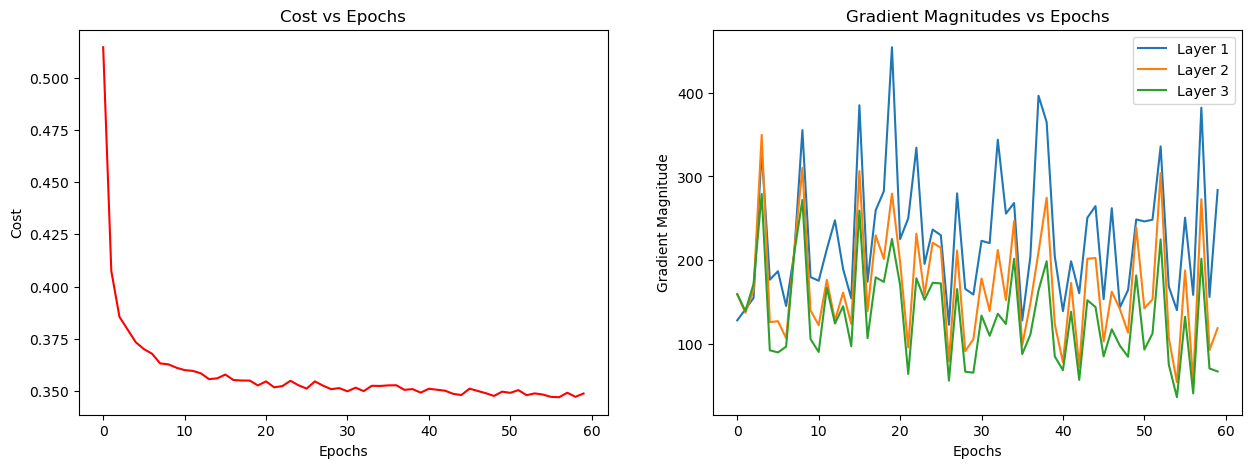

In [537]:
y_pred = model4.predict(X_test)
print('Test accuracy: %.2f%%' % (accuracy_score(y_test, y_pred)*100))
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
cost_avgs = np.mean(model4.cost_,axis=1)
ax1.plot(range(len(cost_avgs)), cost_avgs, color='red')
ax1.set_ylabel('Cost')
ax1.set_xlabel('Epochs')
ax1.set_title('Cost vs Epochs')
for i in range(len(model4.w_grad_)):
    ax2.plot(range(len(model4.w_grad_[i])), model4.w_grad_[i], label="Layer {}".format(i+1))
ax2.set_ylabel('Gradient Magnitude')
ax2.set_xlabel('Epochs')
ax2.set_title('Gradient Magnitudes vs Epochs')
ax2.legend()
plt.show()

When adding a third layer, the cost function behaves similarly and begins to level off around 8 epochs. At the end of the 10 epochs, all three layers have similar gradient magnitudes. The gradient magnitudes of layer 1 and 2 are slightly higher than the gradient magnitude of layer 3 at the end of the 10 epochs.

### 4 Layer Model

In [538]:
hyper_params["n_layers"] = 4
model5 = MultiLayerPerceptron(**hyper_params)
model5.fit(X_train, y_train, print_progress=1, XY_test=(X_test,y_test))

Epoch: 60/60

Test accuracy: 73.14%


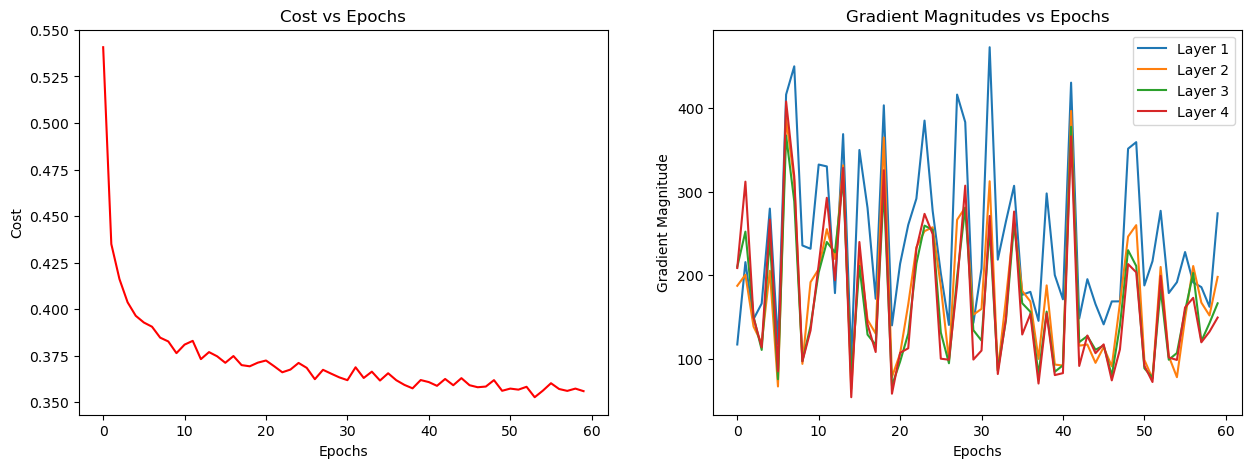

In [539]:
y_pred = model5.predict(X_test)
print('Test accuracy: %.2f%%' % (accuracy_score(y_test, y_pred)*100))
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
cost_avgs = np.mean(model5.cost_,axis=1)
ax1.plot(range(len(cost_avgs)), cost_avgs, color='red')
ax1.set_ylabel('Cost')
ax1.set_xlabel('Epochs')
ax1.set_title('Cost vs Epochs')
for i in range(len(model5.w_grad_)):
    ax2.plot(range(len(model5.w_grad_[i])), model5.w_grad_[i], label="Layer {}".format(i+1))
ax2.set_ylabel('Gradient Magnitude')
ax2.set_xlabel('Epochs')
ax2.set_title('Gradient Magnitudes vs Epochs')
ax2.legend()
plt.show()

We get similar results when adding the 4th layer. The cost seems to level off at around 7 epochs. At the end of the 10 epochs the 1st layer has a higher gradient magnitude than the other 3. The last 3 layers also have very similar magnitudes throughout the 10 epochs while the 1st layer differs slightly.

### 5 Layer Model

In [540]:
hyper_params["n_layers"] = 5
model6 = MultiLayerPerceptron(**hyper_params)
model6.fit(X_train, y_train, print_progress=1, XY_test=(X_test,y_test))

Epoch: 60/60

Test accuracy: 73.71%


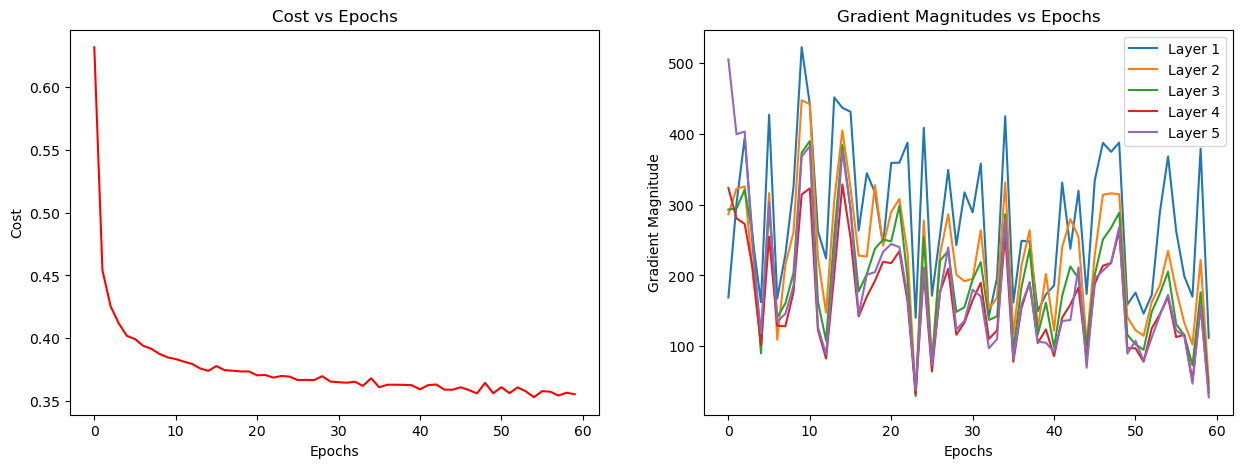

In [541]:
y_pred = model6.predict(X_test)
print('Test accuracy: %.2f%%' % (accuracy_score(y_test, y_pred)*100))
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
cost_avgs = np.mean(model6.cost_,axis=1)
ax1.plot(range(len(cost_avgs)), cost_avgs, color='red')
ax1.set_ylabel('Cost')
ax1.set_xlabel('Epochs')
ax1.set_title('Cost vs Epochs')
for i in range(len(model6.w_grad_)):
    ax2.plot(range(len(model6.w_grad_[i])), model6.w_grad_[i], label="Layer {}".format(i+1))
ax2.set_ylabel('Gradient Magnitude')
ax2.set_xlabel('Epochs')
ax2.set_title('Gradient Magnitudes vs Epochs')
ax2.legend()
plt.show()

Similarly to the last two layers, the cost function levels off at around 7 epochs. The gradient magnitude of the 1st layer is noticeably higher than the others at the end of the 10 epochs. The 3rd, 4th, and 5th layers have similar gradient magnitudes throughout the 10 epochs. Once again we see that the gradient of the first layer differs slightly more from the others throughout the 10 epochs.

### AdaDelta model

In [556]:
class AdaDeltaMLP(MultiLayerPerceptron):
    def __init__(self, B1=.9, B2=.999, epsilon = 10e-8, **kwargs):
        super().__init__(**kwargs)
        self.epsilon = epsilon
        self.B1 = B1
        self.B2 = B2

    def fit(self, X, y, print_progress=False, XY_test=None):
        """ Learn weights from training data. With mini-batch"""
        X_data, y_data = X.copy(), y.copy()
        Y_enc = self._encode_labels(y)
        
        # init weights and setup matrices
        self.n_features_ = X_data.shape[1]
        self.n_output_ = Y_enc.shape[0]
        self._initialize_weights()

        #instantiating the list of arrays for storing the gradient magnitudes for each layer across each epoch
        self.w_grad_ = [np.zeros(self.epochs, dtype=np.float64) for i in range(self.n_layers)]
        # start momentum at zero for previous updates
        Vk_prev = []
        Mk_prev = []

        for w in self.weights_:
            Vk_prev.append(np.zeros(w.shape))
            Mk_prev.append(np.zeros(w.shape))

        Vk = Vk_prev
        Mk = Mk_prev
        
        self.cost_ = []
        self.score_ = []
        # get starting acc
        self.score_.append(accuracy_score(y_data,self.predict(X_data)))
        # keep track of validation, if given
        if XY_test is not None:
            X_test = XY_test[0].copy()
            y_test = XY_test[1].copy()
            self.val_score_ = []
            self.val_score_.append(accuracy_score(y_test,self.predict(X_test)))
            
        for i in range(self.epochs):

            # adaptive learning rate

            if print_progress>0 and (i+1)%print_progress==0:
                sys.stderr.write('\rEpoch: %d/%d' % (i+1, self.epochs))
                sys.stderr.flush()

            if self.shuffle:
                idx_shuffle = np.random.permutation(y_data.shape[0])
                X_data, Y_enc, y_data = X_data[idx_shuffle], Y_enc[:, idx_shuffle], y_data[idx_shuffle]

            mini = np.array_split(range(y_data.shape[0]), self.minibatches)
            mini_cost = []
            for idx in mini:

                # feedforward
                A, Z = self._feedforward(X_data[idx])
                
                cost = self._cost(A[-1], Y_enc[:, idx])

                mini_cost.append(cost) # this appends cost of mini-batch only

                # compute gradient via backpropagation
                w_gradients, b_gradients = self._get_gradient(A, Y_enc=Y_enc[:, idx])

                # getting th el1 norm of the gradient for each layer
                for j in range(len(w_gradients)):
                    self.w_grad_[j][i] = np.linalg.norm(w_gradients[j])

                # creating list to store squared gradients               
                Gk = [gradient**2 for gradient in w_gradients]

                # calculating the new squared rolling average of the gradients and squared gradients
                for j,square_grad in enumerate(Gk):
                    Vk[j] = self.B2 * Vk_prev[j] + (1-self.B2) * square_grad
                for j in range(len(w_gradients)):
                    Mk[j] = self.B1 * Mk_prev[j] + (1-self.B1) * w_gradients[j]

                # updating the weights
                for w in range(len(self.weights_)):
                    self.weights_[w] -= self.eta * (Mk[w] / (np.sqrt(Vk[w] + self.epsilon)))
                    self.biases_[w] -= self.eta * b_gradients[w]


                Vk_prev = Vk
                Mk_prev = Mk

            self.cost_.append(mini_cost)
            self.score_.append(accuracy_score(y_data,self.predict(X_data)))
            if XY_test is not None:
                self.val_score_.append(accuracy_score(y_test,self.predict(X_test)))
            
        return self

    

In [550]:

hyper_params['epochs'] = 60
hyper_params["n_layers"] = 5
hyper_params["B1"] = .8
hyper_params["B2"] = .8
model7 = AdaDeltaMLP(**hyper_params)
model7.fit(X_train, y_train, print_progress=1, XY_test=(X_test,y_test))

Epoch: 60/60

Test accuracy: 73.31%


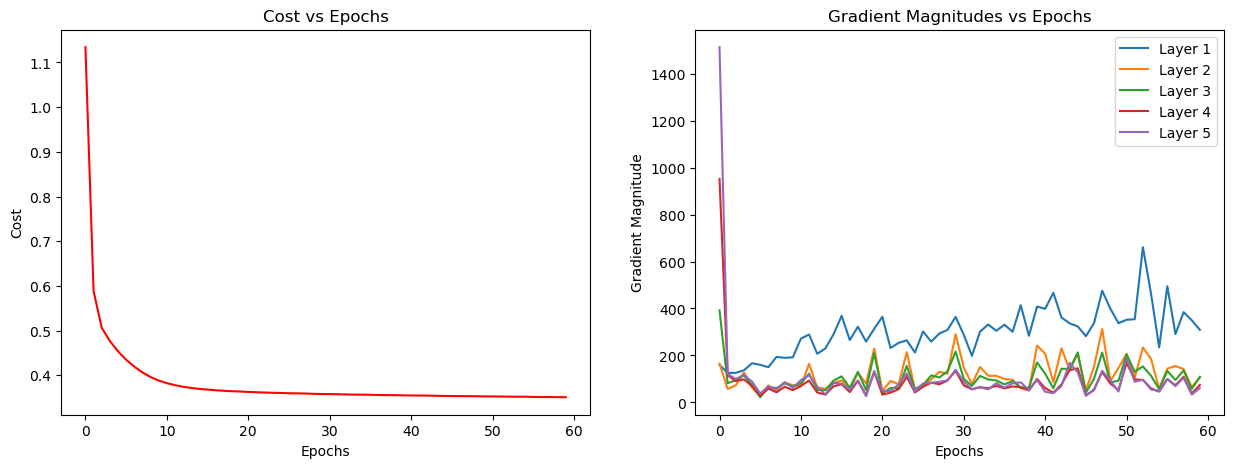

In [551]:
y_pred = model7.predict(X_test)
print('Test accuracy: %.2f%%' % (accuracy_score(y_test, y_pred)*100))
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
cost_avgs = np.mean(model7.cost_,axis=1)
ax1.plot(range(len(cost_avgs)), cost_avgs, color='red')
ax1.set_ylabel('Cost')
ax1.set_xlabel('Epochs')
ax1.set_title('Cost vs Epochs')
for i in range(len(model7.w_grad_)):
    ax2.plot(range(len(model7.w_grad_[i])), model7.w_grad_[i], label="Layer {}".format(i+1))
ax2.set_ylabel('Gradient Magnitude')
ax2.set_xlabel('Epochs')
ax2.set_title('Gradient Magnitudes vs Epochs')
ax2.legend()
plt.show()

This model implements Ada-delta in the fit function, by using a exponential moving average of the gradient as well as the squared gradient to generate an adaptive update that decorates on high gradient areas and speeds up on plateaus. Additionally, the exponential moving average of the momentum provides a better gradient based update, offering faster convergence than the vanilla momentum update. The gradients also become much closer in magnitude compared to the other layers. as seen by how close the gradient magnitudes are for the first layer and other layers.

Exponential moving averages addresses the issue or dealing with sparse data that arise in adaptive learning rate methods like Nesterov's Momentum and Momentum. Rather than using one average gradient, AdaDelta and AdaGrad computer the average gradient for each individual element in the weight matrix. This allows the algorithm to adapt to the sparsity of the data and thus converge faster. AdaDelta addresses the issue of monotonically decreasing learning rates by using a exponentially decaying average of the squared gradient to generate an adaptive update that decorates on high gradient areas and speeds up on plateaus. Additionally, the exponentially decaying average of the momentum provides a better gradient based update, offering faster convergence than the vanilla momentum update.

From the graph, we get much faster convergence, with the loss plateauing at around 20 epochs for Adadelta compared to 60 epochs for the vanilla 5 layer model, which is a significant improvement. However, the ending loss and accuracy are roughly the same, as can be seen from the graph and the fact that we achieved roughly 73% accuracy on the test set in either case.

Fo

### Exceptional Work

In [557]:

class AdaMMLP(AdaDeltaMLP):
    def __init__(self,  **kwds):        
        super().__init__(**kwds)
        
    def fit(self, X, y, print_progress=False, XY_test=None):
        """ Learn weights from training data. With mini-batch"""
        X_data, y_data = X.copy(), y.copy()
        Y_enc = self._encode_labels(y)
        
        # init weights and setup matrices
        self.n_features_ = X_data.shape[1]
        self.n_output_ = Y_enc.shape[0]
        self._initialize_weights()

        #instantiating the list of arrays for storing the gradient magnitudes for each layer across each epoch
        self.w_grad_ = [np.zeros(self.epochs, dtype=np.float64) for i in range(self.n_layers)]

        #inititalizing the decaying average of past and past squared gradients
        moment_1_prev = [np.zeros(w.shape) for w in self.weights_]
        moment_2_prev = [np.zeros(w.shape) for w in self.weights_]

        #inititalizing the decaying average of gradients and squared gradients
        moment_1 = moment_1_prev
        moment_2 = moment_2_prev

        self.cost_ = []
        self.score_ = []
        # get starting acc
        self.score_.append(accuracy_score(y_data,self.predict(X_data)))
        # keep track of validation, if given
        if XY_test is not None:
            X_test = XY_test[0].copy()
            y_test = XY_test[1].copy()
            self.val_score_ = []
            self.val_score_.append(accuracy_score(y_test,self.predict(X_test)))
            
        for i in range(self.epochs):


            if print_progress>0 and (i+1)%print_progress==0:
                sys.stderr.write('\rEpoch: %d/%d' % (i+1, self.epochs))
                sys.stderr.flush()

            if self.shuffle:
                idx_shuffle = np.random.permutation(y_data.shape[0])
                X_data, Y_enc, y_data = X_data[idx_shuffle], Y_enc[:, idx_shuffle], y_data[idx_shuffle]

            mini = np.array_split(range(y_data.shape[0]), self.minibatches)
            mini_cost = []
            for idx in mini:

                # feedforward
                A, Z = self._feedforward(X_data[idx])
                
                cost = self._cost(A[-1], Y_enc[:, idx])

                mini_cost.append(cost) # this appends cost of mini-batch only

                # compute gradient via backpropagation
                w_gradients, b_gradients = self._get_gradient(A, Y_enc=Y_enc[:, idx])

                for j in range(len(w_gradients)):
                    self.w_grad_[j][i] = np.linalg.norm(w_gradients[j])

                # calculating rolling averages for 1st and 2nd moments
                for j,gradient in enumerate(w_gradients):
                    moment_1[j] = self.B1 * moment_1_prev[j] + (1 - self.B1) * gradient
                    moment_2[j] = self.B2 * moment_2_prev[j] + (1 - self.B2) * gradient**2

                # correcting bias in 1st and 2nd moments
                moment_1_hat = [m/(1-self.B1**(i+1)) for m in moment_1]
                moment_2_hat = [m/(1-self.B2**(i+1)) for m in moment_2]

                # updating weights
                for w in range(len(self.weights_)):
                    self.weights_[w] -= self.eta * (moment_1_hat[w] / (np.sqrt(moment_2_hat[w] + self.epsilon)))
                    self.biases_[w] -= self.eta * b_gradients[w]
                    
                moment_1_prev = moment_1
                moment_2_prev = moment_2
                

            self.cost_.append(mini_cost)
            self.score_.append(accuracy_score(y_data,self.predict(X_data)))
            if XY_test is not None:
                self.val_score_.append(accuracy_score(y_test,self.predict(X_test)))
            
        return self

In [560]:

hyper_params['epochs'] = 60
hyper_params["n_layers"] = 5
hyper_params["B1"] = .8
hyper_params["B2"] = .8
model8 = AdaMMLP(**hyper_params)
model8.fit(X_train, y_train, print_progress=1, XY_test=(X_test,y_test))

Epoch: 60/60

Test accuracy: 73.33%


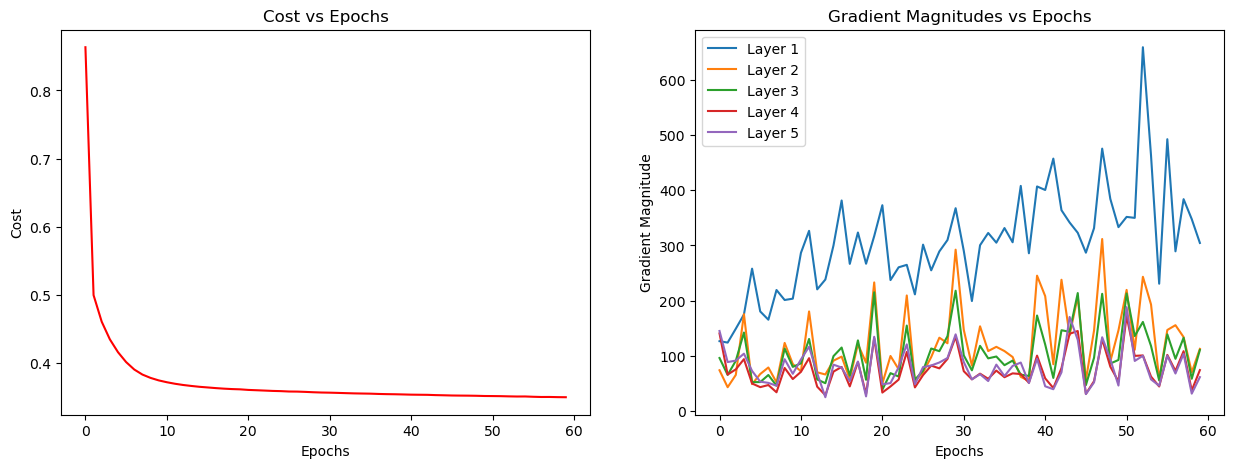

In [561]:
y_pred = model8.predict(X_test)
print('Test accuracy: %.2f%%' % (accuracy_score(y_test, y_pred)*100))
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
cost_avgs = np.mean(model8.cost_,axis=1)
ax1.plot(range(len(cost_avgs)), cost_avgs, color='red')
ax1.set_ylabel('Cost')
ax1.set_xlabel('Epochs')
ax1.set_title('Cost vs Epochs')
for i in range(len(model8.w_grad_)):
    ax2.plot(range(len(model8.w_grad_[i])), model8.w_grad_[i], label="Layer {}".format(i+1))
ax2.set_ylabel('Gradient Magnitude')
ax2.set_xlabel('Epochs')
ax2.set_title('Gradient Magnitudes vs Epochs')
ax2.legend()
plt.show()

ADAM uses a similar process to Ada-delta but adds a boosting of the moments (the exponentially decaying momentum and squared gradient terms). This has the effect of limiting the inherent bias toward 0 due to how the Mk and Vk are initialized, but, as k grows toward larger values, the moment estimate approaches the actual values of Mk and Vk respectively, meaning the convergence should be better compared to AdaDelta, in theory. In the graphs we see that the convergence is slightly faster than Ada-delta with the same exact parameters, in about 10 less iterations based on the loss-epoch graph. The gradients for ADAM are also consistently higher than the other layers but this doesn't seem to affect the convergence.
Adam achieves even faster convergence than Adadelta, with the loss converging around 10 iterations, but tthe ending accuracy is roughly the same as the vanilla model and Adadelta with a test accuracy of, again, roughly 73 percent.